In [3]:
from IPython.display import display
import matplotlib.pyplot as plt

# Random Forests

Spencer Boucher

[Source Code](https://github.com/justmytwospence/random-forests-lesson)

## Leaning Objectives

- Why random forests?
- Review of decision trees (especially spitting criteria)
- Bagging
- The random subspace method
- Tuning hyperparameters
- Variable importance

## Why random Forests?

- Modern: developed in the 1990s by [Tin Kam Ho](http://www.machine-learning.martinsewell.com/ensembles/rsm/Ho1998.pdf), [Leo Breiman, and Adele Cutler](http://machinelearning202.pbworks.com/w/file/fetch/60606349/breiman_randomforests.pdf)
- Works well for *both* **regression** *and* **classification**
- Handles **categorical** features, **numeric** features, and **missing data** well
- Has many convenient and efficient implementations, including `sklearn`
- Requires relatively little tuning
- Highly parallelizable

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

titanic_data = pd.read_csv("data/titanic.csv")
titanic_data = titanic_data.fillna({"Cabin":"NA", "Embarked": "NA"}).apply(le.fit_transform)
display(titanic_data.head())
survived = titanic_data.pop("Survived")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,2,108,1,28,1,0,523,18,146,3
1,1,1,0,190,0,51,1,0,596,207,81,0
2,2,1,2,353,0,34,0,0,669,41,146,3
3,3,1,0,272,0,47,1,0,49,189,55,3
4,4,0,2,15,1,47,0,0,472,43,146,3


## Decision Trees

![classification-tree](images/classification-tree.png)

![regression-tree](images/regression-tree.png)

# Splitting Criteria

- Regression
  - MSE
- Classificatoin
  - misclassication error
  - entropy
  - Gini index

## Misclassification error

- Not continuously differentiable
- Ends up not being as sensitive as we would like in practice

## Entropy (information gain)

$$\textit{Entropy}: H(E) = -\sum_{j=1}^{c}p_j\log p_j$$

- information gain is the entropy of the parent node minus the entropy of the child nodes
- from information theory
- continuously differentiable
- favors pure nodes even in situations with equal misclassification rate
- requires taking a logarithm

## Gini
$$\textit{Gini}: \mathit{Gini}(E) = 1 - \sum_{j=1}^{c}p_j^2$$

- from statistics
- related to the Gini Coefficient for measuring wealth inequality
- computationally simple (no logarithm)
- also continuously differentiable
- also favors pure nodes more than classification error does

## Which should you use?

![gini-vs-entropy](images/gini-vs-entropy.png)

- Use Gini if you are sticking with just one
- Or: treat it as hyperparameter

## The bias variance tradeoff

![bias-variance](images/bias-variance.png)


How have we seen the high variance of trees handled before? (hint: involved a parameter $\alpha$)

Cost-complexity pruning

## **B**ootstrap **AGG**regat**ING**

- We can train *many* trees on bootstrapped samples
- Every tree will have the same bias, but by combining their estimates, we reduce overall variance
- Classification: every individual tree "votes" on the class or 
- Regression: average each tree

![bias-variance](images/bias-variance.png)

Any given observation will only be used to fit $1 - \frac{1}{e}$ of the trees in the forest ($63\%$).

In [5]:
import numpy as np
from string import ascii_lowercase

print(ascii_lowercase, 
      "-> unique letters: ",
      len(ascii_lowercase))
sample = np.random.choice(list(ascii_lowercase),  
                          len(ascii_lowercase),
                          replace=True)
print(''.join(sample), 
      "-> unique letters: ",
      len(set(sample)))

print('Proportion of letters in sample: {:.1%}'.format(len(set(sample))/len(sample)))

abcdefghijklmnopqrstuvwxyz -> unique letters:  26
wwupwqbwhrofclwhslnpzuttqu -> unique letters:  15
Proportion of letters in sample: 57.7%


## Out-of-bag error estimates

- We can average or vote with the remaining $37\%$ of trees to make a prediction for each observation.
- This is called the out-of-bag error (OOB).
- For sufficiently large forest size, OOB error approaches LOO error.

![images](images/oob-vs-test-error.png)

## Random subspace method

- Bagging suffers from the problem that trees tend to be very similar to one another
- We can *decorrelate* trees in the forest by bagging the *features* as well
- Wisdom of the crowds analogy redux
- Every time we consider a split, limit our choices to $m$ of the $p$ variables in the dataset
- $m$ is often defaulted to $\sqrt(p)$, but can reasonbly be as low as $1$

![m-vs-p](images/m-vs-p.png)

In [6]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=1000, 
                                criterion='gini',
                                max_features='sqrt',
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1)
forest.fit(titanic_data, survived)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

## Hyperparameters

- `criterion`
- `max_depth`: maximum depth of an individual tree
- `min_samples_split`: minimum number of samples required to split
- `min_samples_leaf`: minimum number of samples required to be at a leaf node
- `min_impurity_decrease`: minimum impurity decrease that can cause a split
- [Visual demo widget](https://cs.stanford.edu/%7Ekarpathy/svmjs/demo/demoforest.html)

## Grid Search

In [7]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(n_estimators=100)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 10, 'sqrt', 'log2'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
grid_search.fit(titanic_data, survived)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 10, 'sqrt', 'log2'], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# Variable Importance

Two methods:

1. Mean impurity decrease: Add up the decreases in Gini index across every tree when a given variable is used for a split. The units on this meassure for a particular feature are meaningless. They are only interesting relative to each other.

2. Mean accuracy decrease: Measure the decrease in accuracy on OOB data when values of each feature are randomly permuted (effectively annihilating it's signal)

The `feature_importances_` attribute in `sklearn` uses method #1.

In [12]:
importances[indices]

array([0.23693219, 0.13305347, 0.11576553, 0.1134657 , 0.10969246,
       0.10099355, 0.06035738, 0.05939177, 0.02786738, 0.02337968,
       0.0191009 ])

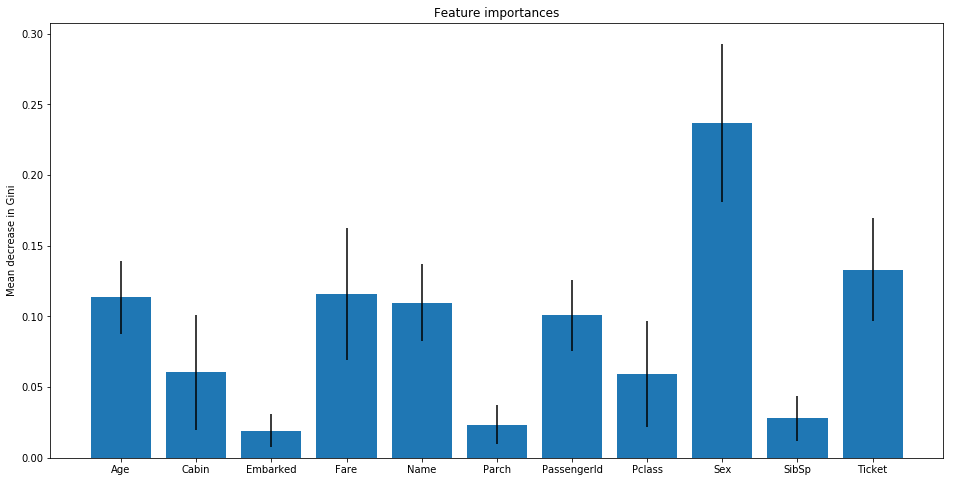

In [9]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(16,8)); plt.title("Feature importances"); plt.ylabel("Mean decrease in Gini")
plt.bar(titanic_data.columns[indices], importances[indices], yerr=std[indices])
plt.show()

## Disadvantages

- Can give wonky results on data that falls outside the range of the training data
- Less interpretable than many models
- Relatively slow at prediction time

## Summary

- Random forests reduce the variance of a single decision tree
  - Bootstrap sampling the data
  - Random feature subspace
- Error can be computed ("for free") on the out-of-bag observations

# Appendix

## Evaluating Performance 

The output of a random forest *classifier* is actually a proportion.

This means that we don't have to limit ourselves to a hard classification according to the majority; we can do some other interesting things

## ROC curves

One thing we can do is calibrate our predictions according to how aggressive or conservative we want to be.

![roc-curve](images/roc-curve.png)

## log-loss

![log-loss](images/log-loss.png)

## Trees vs linear models

![tree-vs-linear](images/tree-vs-linear.png)

## Bagging vs Boosting

![rf-bagging-boosting](images/rf-bagging-boosting.png)